In [1]:
from nnsight import LanguageModel

LanguageModel("bigscience/bloom-7b1")

BloomForCausalLM(
  (transformer): BloomModel(
    (word_embeddings): Embedding(250880, 4096)
    (word_embeddings_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
    (h): ModuleList(
      (0-29): 30 x BloomBlock(
        (input_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (self_attention): BloomAttention(
          (query_key_value): Linear(in_features=4096, out_features=12288, bias=True)
          (dense): Linear(in_features=4096, out_features=4096, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (post_attention_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (mlp): BloomMLP(
          (dense_h_to_4h): Linear(in_features=4096, out_features=16384, bias=True)
          (gelu_impl): BloomGelu()
          (dense_4h_to_h): Linear(in_features=16384, out_features=4096, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
  )


In [1]:
import json
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
import torch as th

%load_ext autoreload
%autoreload 3
from time import time
from coolname import generate_slug

In [2]:
from src.display_utils import plot_ci


def plot_dict(
    json_dic,
    title="",
    skip=[],
    colors=None,
    ax=None,
    do_y_label=True,
    do_probs_hor=True,
    baseline_colors=None,
    legend=True,
    save_png=False,
):
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))

    if colors is None:
        colors = sns.color_palette("tab10", len(json_dic) + 1)
    colors_it = iter(colors)
    if baseline_colors is None:
        baseline_colors = [colors[0], colors[3] if len(colors) > 3 else colors[1]]
    first = True
    for latent_lang in json_dic.keys():
        if "baseline" in latent_lang or latent_lang in skip:
            continue
        if "probs" in latent_lang:
            if do_probs_hor:
                is_source = "src" in latent_lang or "source" in latent_lang
                color = baseline_colors[0] if is_source else baseline_colors[1]
                ax.axhline(
                    np.mean(json_dic[latent_lang]),
                    # label=latent_lang,
                    color=color,
                    linestyle="--" if is_source else "-.",
                    alpha=0.6,
                )
            continue
        if not isinstance(json_dic[latent_lang], list):
            continue
        probs = th.tensor(json_dic[latent_lang])
        num_layers = probs.shape[1]
        plot_ci(
            ax,
            probs,
            label=latent_lang,
            color=next(colors_it),
            init=first,
            tik_step=5,
        )
        first = False
    if legend:
        ax.legend()
    ax.set_title(title)
    print(num_layers)
    ax.tick_params(labelsize=15)
    ax.set_xlabel("layer", fontsize=16)
    if do_y_label:
        ax.set_ylabel("concept probability", fontsize=16)
    ax.set_xlim(0, num_layers - 1)
    ax.set_ylim(0, 1)
    if fig is not None:
        fig.tight_layout()
    # Save the plot
    id = str(int(time())) + generate_slug(2)
    if save_png:
        path = Path(f"plots/{id}.png")
        path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(path, dpi=300, bbox_inches="tight")
    path = Path(f"plots/{id}.pdf")
    path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print(f"Saved plot to {path}")
    plt.show()


def load_dict(file):
    with open(file, "r") as f:
        json_dic = json.load(f)
    return json_dic


def plot_file(file, title="", skip=[], **kwargs):
    json_dic = load_dict(file)
    plot_dict(json_dic, title, skip, **kwargs)

32
Saved plot to plots/1723231358elite-donkey.pdf


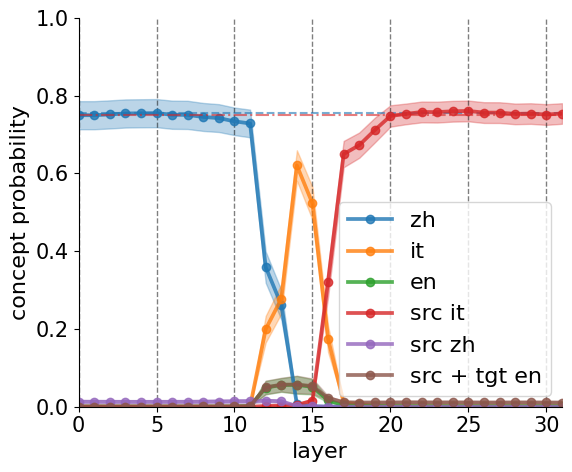

In [4]:
plot_file(
    "results/Llama-2-7b/shifted_translation/de_it-fr_zh/1723223416_gray-crab.json"
)